# TSNN examples

## Summary

- In narrow format, both lin reg and fully connected manage to capture a linear effect between features and target. A linear regression will always be better in this case since this is constrained to be exactly the function of the ground truth


In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils

plt.style.use('ggplot')

In [2]:
z = generators.Generator(1000, 100, 10)

In [3]:
%%time
X, y = z.generate_dataset(pct_zero_corr = 0.5,
                            split_conditional = 0.2,
                            split_shift = 0.2,
                            split_seasonal = 0.2)

CPU times: user 367 ms, sys: 62.1 ms, total: 429 ms
Wall time: 57.7 ms


In [4]:
train, test = utils.np_to_torch(X, y)

### Simple benchmarks

In [5]:
# lasso benchmark
lasso = ml_benchmarks.LassoBenchmark()
lasso.fit(train)

In [6]:
lasso.score(train)

np.float64(0.028259200256149638)

In [7]:
# any custom benchmark
from sklearn.linear_model import LinearRegression
lr = ml_benchmarks.CustomBenchmark(LinearRegression())
lr.fit(train)

In [8]:
comp = benchmark_comparison.Comparator(models=[lasso, lr], model_names=['lasso', 'lr'])

In [9]:
# comp.correl(train, z.y_pred_optimal[train.dataset.indices].flatten())
comp.correl(train, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso
y_optimal,0.0336,nan,nan,nan,nan,nan,nan
y_linear,0.0274,0.8009,nan,nan,nan,nan,nan
y_seasonal,0.0055,0.1181,-0.0000,nan,nan,nan,nan
y_conditional,0.0202,0.5447,0.0000,-0.0011,nan,nan,nan
y_shift,-0.0001,0.2140,-0.0035,-0.0011,-0.0027,nan,nan
lasso,0.0283,0.7917,0.9890,0.0003,-0.0010,-0.0032,nan
lr,0.0292,0.7466,0.9398,-0.0319,-0.0017,-0.0097,0.9691


In [10]:
comp.correl(test, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso
y_optimal,0.0382,nan,nan,nan,nan,nan,nan
y_linear,0.0317,0.8044,nan,nan,nan,nan,nan
y_seasonal,0.0092,0.1167,0.0025,nan,nan,nan,nan
y_conditional,0.0210,0.5445,0.0062,-0.0017,nan,nan,nan
y_shift,0.0019,0.2221,0.0023,-0.0103,0.0023,nan,nan
lasso,0.0317,0.7952,0.9889,0.0029,0.0047,0.0041,nan
lr,0.0302,0.7508,0.9385,-0.0287,0.0058,-0.0001,0.9685


## Torch benchmarks - narrow matrix (no cross-TS interactions)

### Fully connected

Equivalent to linear regression setup

In [11]:
train, test = utils.np_to_torch(X, y, narrow=True)

In [12]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_f, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
        
    def forward(self, x):
        pred = self.linear_relu_stack(x)
        return pred

In [13]:
m = NeuralNetwork(n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-2)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [14]:
full_nn.fit(train, test, epochs=20)

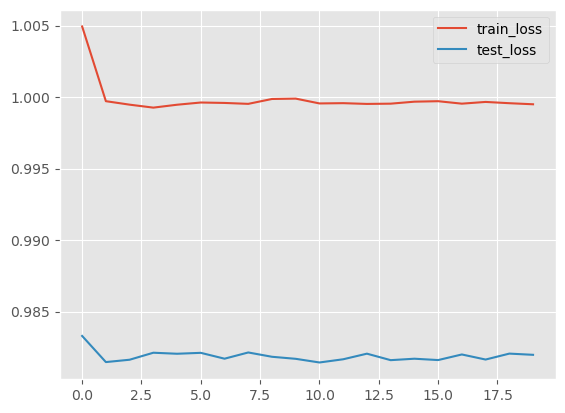

In [15]:
pd.concat([pd.Series(full_nn.train_loss).rename('train_loss'), pd.Series(full_nn.test_loss).rename('test_loss')], axis=1).plot();

In [16]:
comp = benchmark_comparison.Comparator(models=[full_nn], model_names=['nn'])

In [17]:
opt_dim = z.y_pred_optimal.shape
comp.correl(train, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift
y_optimal,0.0336,nan,nan,nan,nan,nan
y_linear,0.0274,0.8009,nan,nan,nan,nan
y_seasonal,0.0055,0.1181,-0.0000,nan,nan,nan
y_conditional,0.0202,0.5447,0.0000,-0.0011,nan,nan
y_shift,-0.0001,0.2140,-0.0035,-0.0011,-0.0027,nan
nn,0.0251,0.5127,0.6126,-0.0714,0.0574,-0.0061


In [18]:
comp.correl(test, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift
y_optimal,0.0382,nan,nan,nan,nan,nan
y_linear,0.0317,0.8044,nan,nan,nan,nan
y_seasonal,0.0092,0.1167,0.0025,nan,nan,nan
y_conditional,0.0210,0.5445,0.0062,-0.0017,nan,nan
y_shift,0.0019,0.2221,0.0023,-0.0103,0.0023,nan
nn,0.0211,0.5065,0.6019,-0.0688,0.0580,0.0073


### LSTM

Equivalent to linear regression setup

In [19]:
train, test = utils.np_to_torch(X, y, n_rolling=5, narrow=True)

In [20]:
train.collate_fn

<function tsnn.utils.collate_pad_beginning(batch, pad_value=0.0, max_len=None)>

In [21]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_f, hidden_dim=128):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_f, hidden_size=hidden_dim, batch_first=True, num_layers=2)
        self.decoder = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x: (batch, T=10, n_f)
        _, (h, _) = self.encoder(x)
        out = self.decoder(h[-1]) 
        return out

In [22]:
m = LSTMModel(n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [23]:
model_lstm.fit(train, test=test, epochs=10)

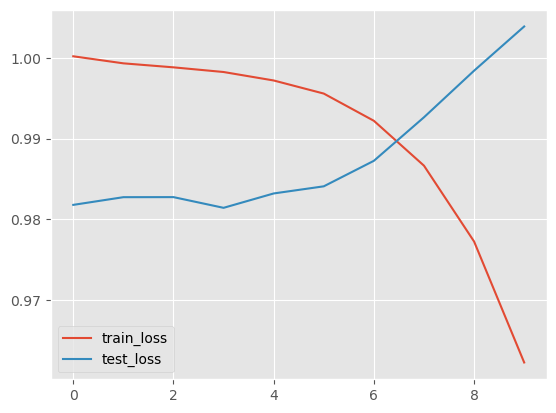

In [24]:
pd.concat([pd.Series(model_lstm.train_loss).rename('train_loss'), pd.Series(model_lstm.test_loss).rename('test_loss')], axis=1).plot();

In [25]:
comp = benchmark_comparison.Comparator(models=[model_lstm], model_names=['lstm'])

In [26]:
opt_dim = z.y_pred_optimal.shape
comp.correl(train, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift
y_optimal,0.0336,nan,nan,nan,nan,nan
y_linear,0.0274,0.8009,nan,nan,nan,nan
y_seasonal,0.0055,0.1181,-0.0000,nan,nan,nan
y_conditional,0.0202,0.5447,0.0000,-0.0011,nan,nan
y_shift,-0.0001,0.2140,-0.0035,-0.0011,-0.0027,nan
lstm,0.2679,0.1976,0.1773,-0.0092,0.0901,0.0343


In [27]:
comp.correl(test, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift
y_optimal,0.0382,nan,nan,nan,nan,nan
y_linear,0.0317,0.8044,nan,nan,nan,nan
y_seasonal,0.0092,0.1167,0.0025,nan,nan,nan
y_conditional,0.0210,0.5445,0.0062,-0.0017,nan,nan
y_shift,0.0019,0.2221,0.0023,-0.0103,0.0023,nan
lstm,0.0068,0.1960,0.1741,-0.0061,0.0898,0.0406


### Transformer

In [28]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_f, n_rolling, d_model=64, nhead=4, num_layers=1, dropout=0.1):
        super().__init__()
        self.input_dim = n_f
        self.d_model = d_model

        # Linear projection of n_f features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_f)
        B, n_rolling, n_f = x.shape

        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        encoded = self.encoder(x, src_key_padding_mask=mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [29]:
m = TransformerEncoderModel(10, 5).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [30]:
model_torch.fit(train, test=test, epochs=10)

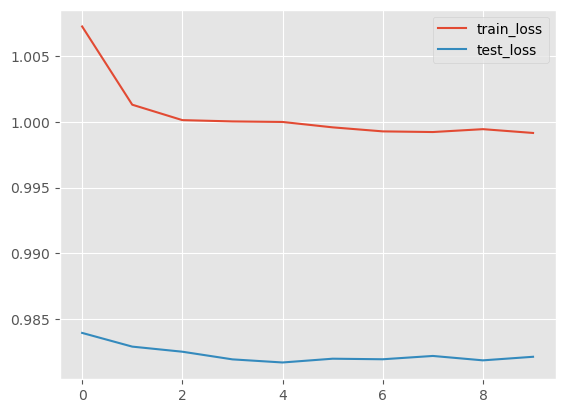

In [31]:
pd.concat([pd.Series(model_torch.train_loss).rename('train_loss'), pd.Series(model_torch.test_loss).rename('test_loss')], axis=1).plot();

In [32]:
comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['transformer'])

In [33]:
comp.correl(train, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift
y_optimal,0.0336,nan,nan,nan,nan,nan
y_linear,0.0274,0.8009,nan,nan,nan,nan
y_seasonal,0.0055,0.1181,-0.0000,nan,nan,nan
y_conditional,0.0202,0.5447,0.0000,-0.0011,nan,nan
y_shift,-0.0001,0.2140,-0.0035,-0.0011,-0.0027,nan
transformer,0.0409,0.2967,0.3598,-0.0251,0.0402,-0.0492


In [34]:
comp.correl(test, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift
y_optimal,0.0382,nan,nan,nan,nan,nan
y_linear,0.0317,0.8044,nan,nan,nan,nan
y_seasonal,0.0092,0.1167,0.0025,nan,nan,nan
y_conditional,0.0210,0.5445,0.0062,-0.0017,nan,nan
y_shift,0.0019,0.2221,0.0023,-0.0103,0.0023,nan
transformer,0.0129,0.2967,0.3592,-0.0316,0.0389,-0.0365


## Torch benchmarks - wide matrix (cross-TS interactions)

### Fully connected

In [35]:
train, test = utils.np_to_torch(X, y)

In [36]:
train.batch_size, test.batch_size

(64, 64)

In [37]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_ts, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            # nn.Linear(512, 512),
            # nn.ReLU(),
            nn.Linear(512, n_ts),
        )
        
        self.linear_relu_stack = nn.Sequential(nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_ts)
                                              )

    def forward(self, x):
        x = self.flatten(x)
        pred = self.linear_relu_stack(x)
        return pred

In [38]:
m = NeuralNetwork(n_ts=100, n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-2)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [39]:
full_nn.fit(train, test, epochs=20)

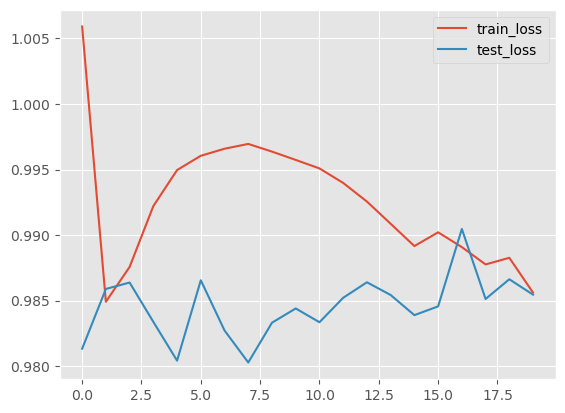

In [40]:
pd.concat([pd.Series(full_nn.train_loss).rename('train_loss'), pd.Series(full_nn.test_loss).rename('test_loss')], axis=1).plot();

In [41]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, full_nn], model_names=['lasso', 'lr', 'nn'])

In [42]:
comp.correl(train, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso,lr
y_optimal,0.0336,nan,nan,nan,nan,nan,nan,nan
y_linear,0.0274,0.8009,nan,nan,nan,nan,nan,nan
y_seasonal,0.0055,0.1181,-0.0000,nan,nan,nan,nan,nan
y_conditional,0.0202,0.5447,0.0000,-0.0011,nan,nan,nan,nan
y_shift,-0.0001,0.2140,-0.0035,-0.0011,-0.0027,nan,nan,nan
lasso,0.0283,0.7917,0.9890,0.0003,-0.0010,-0.0032,nan,nan
lr,0.0292,0.7466,0.9398,-0.0319,-0.0017,-0.0097,0.9691,nan
nn,0.1438,0.0066,0.0097,0.0049,-0.0011,-0.0053,0.0099,0.0085


In [43]:
comp.correl(test, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso,lr
y_optimal,0.0382,nan,nan,nan,nan,nan,nan,nan
y_linear,0.0317,0.8044,nan,nan,nan,nan,nan,nan
y_seasonal,0.0092,0.1167,0.0025,nan,nan,nan,nan,nan
y_conditional,0.0210,0.5445,0.0062,-0.0017,nan,nan,nan,nan
y_shift,0.0019,0.2221,0.0023,-0.0103,0.0023,nan,nan,nan
lasso,0.0317,0.7952,0.9889,0.0029,0.0047,0.0041,nan,nan
lr,0.0302,0.7508,0.9385,-0.0287,0.0058,-0.0001,0.9685,nan
nn,-0.0021,-0.0005,-0.0004,0.0037,0.0018,-0.0073,0.0004,0.0017


### LSTM model with 10 timestamps

In [44]:
train, test = utils.np_to_torch(X, y, n_rolling=10)

In [45]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, hidden_dim=128):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_ts*n_f, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, n_ts)
    
    def forward(self, x):
        # warning: lstm dimension needs to be flattened:
        # x: (batch, T=10, n_ts*n_f)
        _, (h, _) = self.encoder(x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]))
        out = self.decoder(h[-1]) 
        return out

In [46]:
m = LSTMModel(n_ts=100, n_f=10, n_rolling=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [47]:
model_lstm.fit(train, test=test, epochs=10)

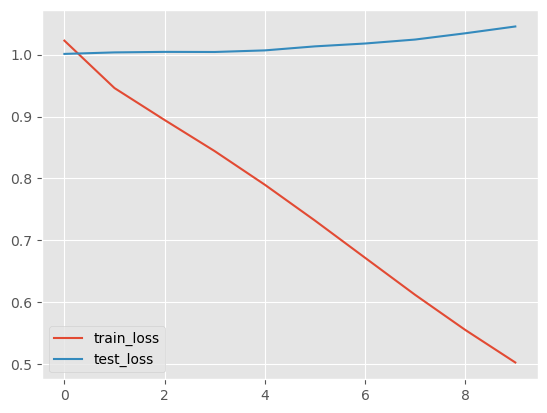

In [48]:
pd.concat([pd.Series(model_lstm.train_loss).rename('train_loss'), pd.Series(model_lstm.test_loss).rename('test_loss')], axis=1).plot();

In [49]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm], model_names=['lasso', 'lr', 'lstm'])

In [50]:
comp.correl(train, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso,lr
y_optimal,0.0336,nan,nan,nan,nan,nan,nan,nan
y_linear,0.0274,0.8009,nan,nan,nan,nan,nan,nan
y_seasonal,0.0055,0.1181,-0.0000,nan,nan,nan,nan,nan
y_conditional,0.0202,0.5447,0.0000,-0.0011,nan,nan,nan,nan
y_shift,-0.0001,0.2140,-0.0035,-0.0011,-0.0027,nan,nan,nan
lasso,0.0283,0.7917,0.9890,0.0003,-0.0010,-0.0032,nan,nan
lr,0.0292,0.7466,0.9398,-0.0319,-0.0017,-0.0097,0.9691,nan
lstm,0.7813,0.0245,0.0192,0.0052,0.0156,0.0001,0.0199,0.0204


In [51]:
comp.correl(test, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso,lr
y_optimal,0.0382,nan,nan,nan,nan,nan,nan,nan
y_linear,0.0317,0.8044,nan,nan,nan,nan,nan,nan
y_seasonal,0.0092,0.1167,0.0025,nan,nan,nan,nan,nan
y_conditional,0.0210,0.5445,0.0062,-0.0017,nan,nan,nan,nan
y_shift,0.0019,0.2221,0.0023,-0.0103,0.0023,nan,nan,nan
lasso,0.0317,0.7952,0.9889,0.0029,0.0047,0.0041,nan,nan
lr,0.0302,0.7508,0.9385,-0.0287,0.0058,-0.0001,0.9685,nan
lstm,0.0182,0.0064,0.0062,0.0049,0.0040,-0.0061,0.0050,0.0048


### Transformer

In [52]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.5):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        encoded = self.encoder(x, src_key_padding_mask=mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [53]:
m = TransformerEncoderModel(100, 10, 10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [54]:
model_torch.fit(train, test=test, epochs=10)

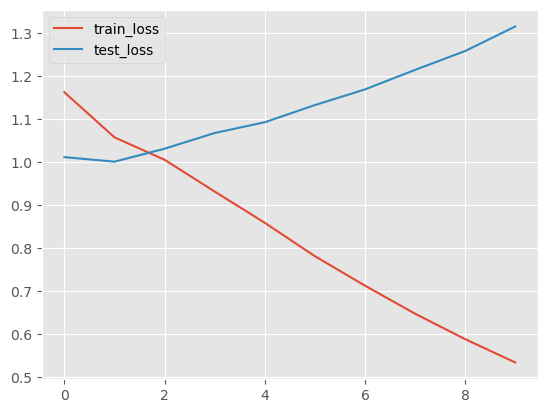

In [55]:
pd.concat([pd.Series(model_torch.train_loss).rename('train_loss'), pd.Series(model_torch.test_loss).rename('test_loss')], axis=1).plot();

In [56]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [57]:
comp.correl(train, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso,lr,lstm
y_optimal,0.0336,nan,nan,nan,nan,nan,nan,nan,nan
y_linear,0.0274,0.8009,nan,nan,nan,nan,nan,nan,nan
y_seasonal,0.0055,0.1181,-0.0000,nan,nan,nan,nan,nan,nan
y_conditional,0.0202,0.5447,0.0000,-0.0011,nan,nan,nan,nan,nan
y_shift,-0.0001,0.2140,-0.0035,-0.0011,-0.0027,nan,nan,nan,nan
lasso,0.0283,0.7917,0.9890,0.0003,-0.0010,-0.0032,nan,nan,nan
lr,0.0292,0.7466,0.9398,-0.0319,-0.0017,-0.0097,0.9691,nan,nan
lstm,0.7813,0.0245,0.0192,0.0052,0.0156,0.0001,0.0199,0.0204,nan
transformer,0.7620,0.0330,0.0301,0.0047,0.0161,-0.0024,0.0309,0.0312,0.6764


In [58]:
comp.correl(test, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso,lr,lstm
y_optimal,0.0382,nan,nan,nan,nan,nan,nan,nan,nan
y_linear,0.0317,0.8044,nan,nan,nan,nan,nan,nan,nan
y_seasonal,0.0092,0.1167,0.0025,nan,nan,nan,nan,nan,nan
y_conditional,0.0210,0.5445,0.0062,-0.0017,nan,nan,nan,nan,nan
y_shift,0.0019,0.2221,0.0023,-0.0103,0.0023,nan,nan,nan,nan
lasso,0.0317,0.7952,0.9889,0.0029,0.0047,0.0041,nan,nan,nan
lr,0.0302,0.7508,0.9385,-0.0287,0.0058,-0.0001,0.9685,nan,nan
lstm,0.0182,0.0064,0.0062,0.0049,0.0040,-0.0061,0.0050,0.0048,nan
transformer,0.0121,0.0111,0.0153,-0.0071,-0.0020,0.0037,0.0175,0.0214,0.2122
